In [1]:
## apt install cm-super dvipng

import csv
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

from math import log
from matplotlib import rc

rc('text', usetex=True)

In [2]:
#lista fontes disponiveis
#import matplotlib.font_manager
#matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [3]:
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 22, 
      'axes.titlesize': 20, 
      'legend.fontsize': 'x-large',
      'font.family':'cmu', 'font.serif':['cmu'],
      'axes.facecolor': 'DFDFE5'}
sns.set_context('paper', rc=rc)
sns.set_style('dark', rc=rc)

In [4]:
def importEvents(file, lab, cols=['ID','Gene','FDR', 'PSI', 'Label']):
    data = pd.read_csv(file, delimiter='\t')
    data['Label'] = lab
    data['PSI'] = data['IncLevelDifference']
    data['Gene'] = data['GeneID']
    if not all([c in list(data.columns) for c in cols]): 
        raise Exception('Load Error in ' + file)
    return data.drop(columns=[c for c in data.columns if not c in cols])

In [5]:
def parseFolder(folder):
    a3ss = importEvents(folder + '/A3SS.MATS.JC.txt', 'A3SS')
    a5ss = importEvents(folder + '/A5SS.MATS.JC.txt', 'A5SS')
    ri = importEvents(folder + '/RI.MATS.JC.txt', 'RI')
    se = importEvents(folder + '/SE.MATS.JC.txt', 'SE')
    mxe = importEvents(folder + '/MXE.MATS.JC.txt', 'MXE')
    pd_all_data = pd.concat([a3ss, a5ss,  ri, se ,mxe])
    pd_all_data['qValue'] = pd_all_data.FDR.map(lambda e:  'ALL' if e > 0.05 else 'SIG')
    pd_all_data['log10fdr'] = pd_all_data.FDR.map(lambda e: -log(e, 10))
    return pd_all_data

In [6]:
def volcano(
                plot_data,
                lab="a",
                tamanho=(6,7),
                paleta="bright",
                x_size=20, y_size=20,
                file='volcano_{lab}_.png',
                legenda='auto'
            ):
    plt.figure(figsize=tamanho)
    sns.color_palette(paleta)
    ax = sns.scatterplot(x="PSI", y="log10fdr", hue="qValue", data=plot_data, linewidth=0, palette=paleta, legend=legenda)
    ax.set_ylabel(r'-$\log_{10}{Q}$').set_path_effects([path_effects.Normal()])
    ax.set_xlabel(r'$\Delta$PSI').set_path_effects([path_effects.Normal()])
    plt.xticks([-1, -.5, 0, .5, 1], fontsize=x_size)
    plt.yticks(fontsize=y_size)

    x = np.linspace(0, plot_data["log10fdr"].max())
    plt.plot([0 for x in x], x, 'k-', lw=1)


    sigs = plot_data.loc[plot_data['Gene'].isin(list(plot_data.loc[plot_data['log10fdr'] > 5].Gene))]

    for x in sigs.iterrows():
        ax.annotate("%s %s" % (x[1]['Label'], x[1]['Gene']), xy=(x[1]['PSI'], x[1]['log10fdr']), 
                ## xytext=(.5, 4), arrowprops=dict(facecolor='black', shrink=0.05)
               )
        
    plt.title(r"\textbf{%s}" % lab, loc='left')
    output = file.replace("{lab}", lab)
    print('Saved as', output)
    plt.savefig(output, dpi=150)
    return plt

In [7]:
def multipleVolcanos(data, output="multipleVolcanos.png",
                     lab_col="Label", psi_col="PSI", fdr_col="log10fdr", sig_col="qValue", 
                     paleta="bright",
                     xlim=(-1, 1), ylim=(0, 8),
                     h=2.5,
                     sig_label="ALL", bicolor=False):
    
    paleta="gray" if bicolor else paleta
    data['hue'] = data["qValue"].map(lambda x: 1 if x == sig_label else 0) if bicolor else data["qValue"]

    # Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(data, col=lab_col, palette=paleta, col_wrap=5, height=h)

    # Draw a horizontal line to show the starting point
    grid.map(plt.axvline, x=0, lw=1, c='k')

    # Draw a line plot to show the trajectory of each random walk
    grid.map(sns.scatterplot, psi_col, fdr_col, 'hue', linewidth=0, palette=paleta)
    
    for ax in grid.axes:
        ax.set_ylabel(r'-$\log_{10}{Q}$').set_path_effects([path_effects.Normal()])
        ax.set_xlabel(r'$\Delta$PSI').set_path_effects([path_effects.Normal()])
        ax.title.set_text(r'\textbf{%s}' % ax.title.get_text().replace('Label = ', ''))
        
    # Adjust the tick positions and labels
    grid.set(xticks=[-1,0,1], xlim=xlim, ylim=ylim)

    # Adjust the arrangement of the plots
    grid.fig.tight_layout(w_pad=1)
    
    print('Saved as', output)
    grid.savefig(output, dpi=150)
    
    return grid

In [8]:
gy, ry  = '../rmats401/resultadosGY/', '../rmats401/resultadosRY/'

In [9]:
gy_dt, ry_dt = parseFolder(gy), parseFolder(ry)

In [10]:
gy_dt.Label = "GY " + gy_dt.Label

In [11]:
ry_dt.Label = "RY " + ry_dt.Label

In [12]:
all_data = pd.concat([gy_dt, ry_dt])

Saved as multipleVolcanos.png


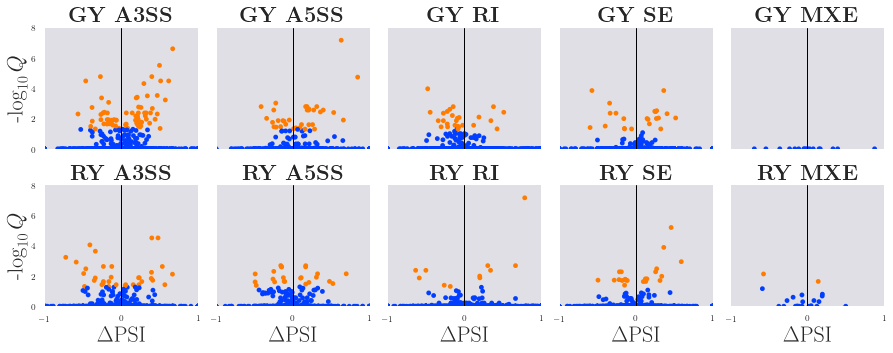

In [13]:
g = multipleVolcanos(all_data)

In [ ]:
volcano(all_data)